<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


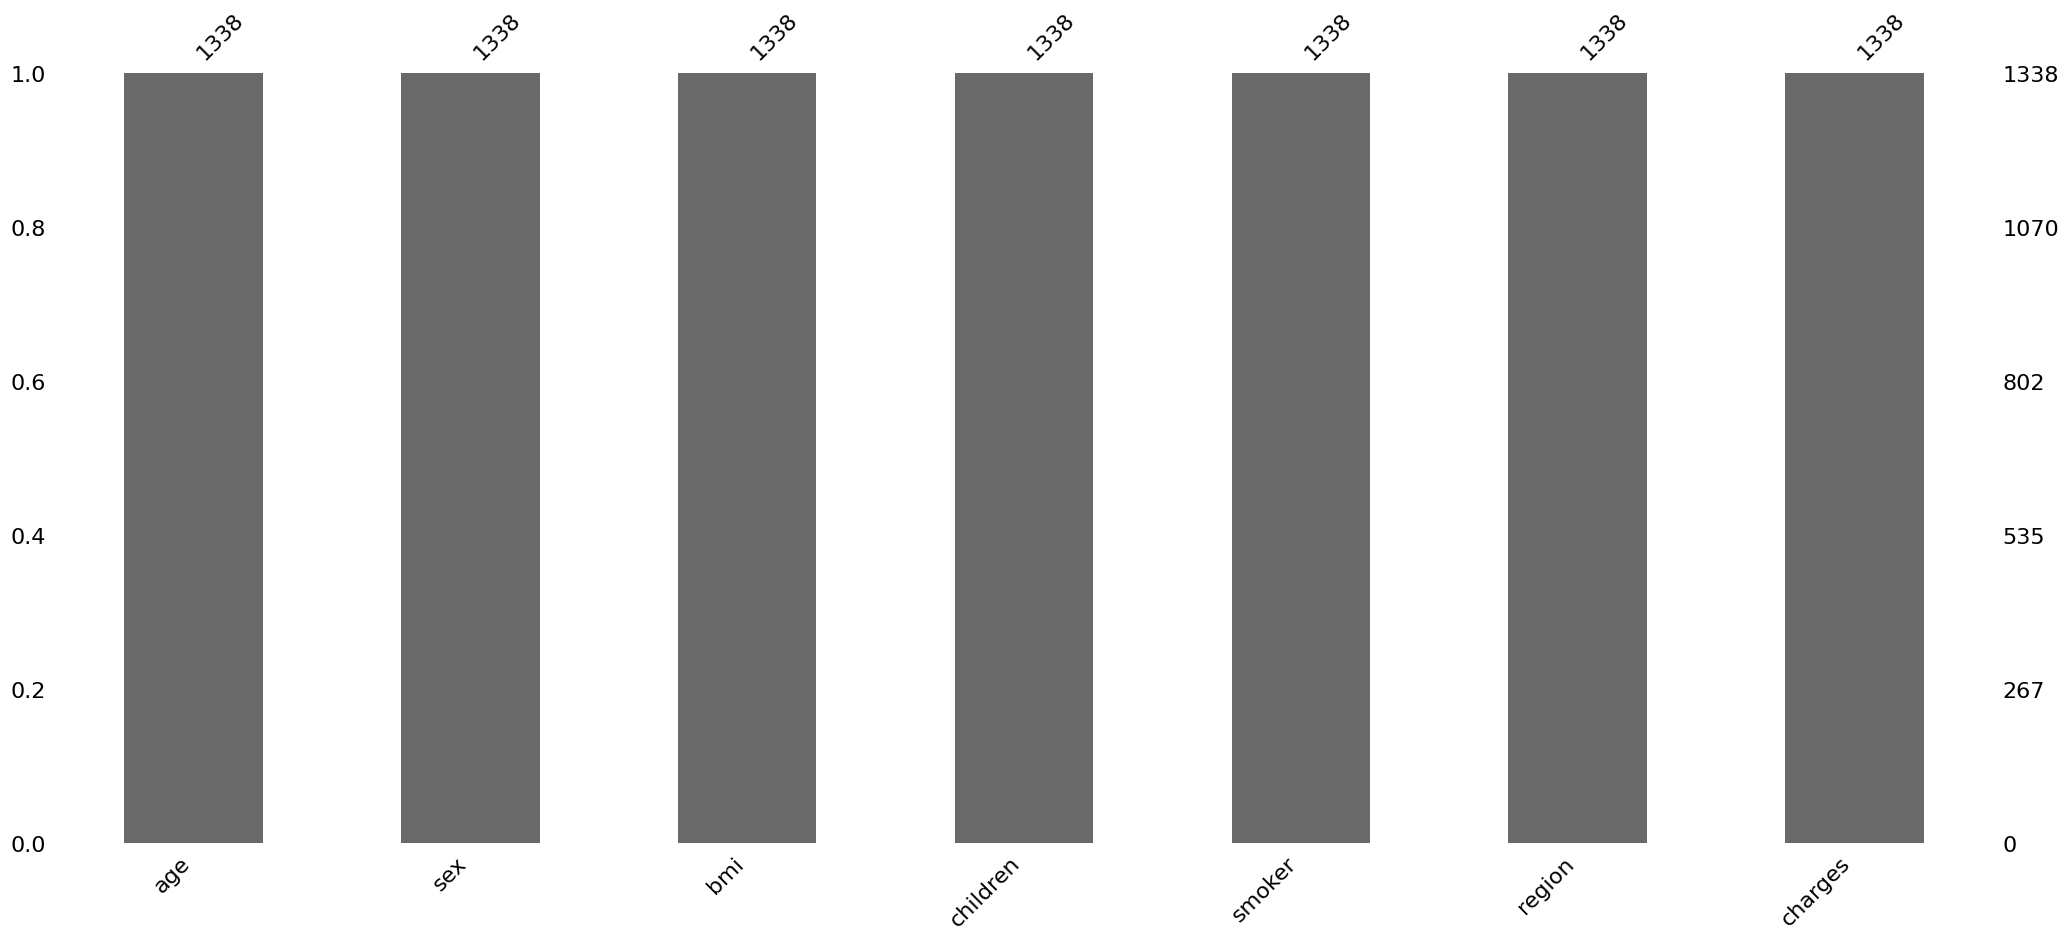

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from patsy import dmatrices
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# display plots inline
%matplotlib inline

# set matplotlib plot size
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

# load dataset
df = pd.read_csv('expenses.csv')

# check for missing values
msno.bar(df)

# check dataset variables and summary statistics
df.info()
df.describe()
#df.head()

array([[<AxesSubplot: title={'center': 'charges'}>]], dtype=object)

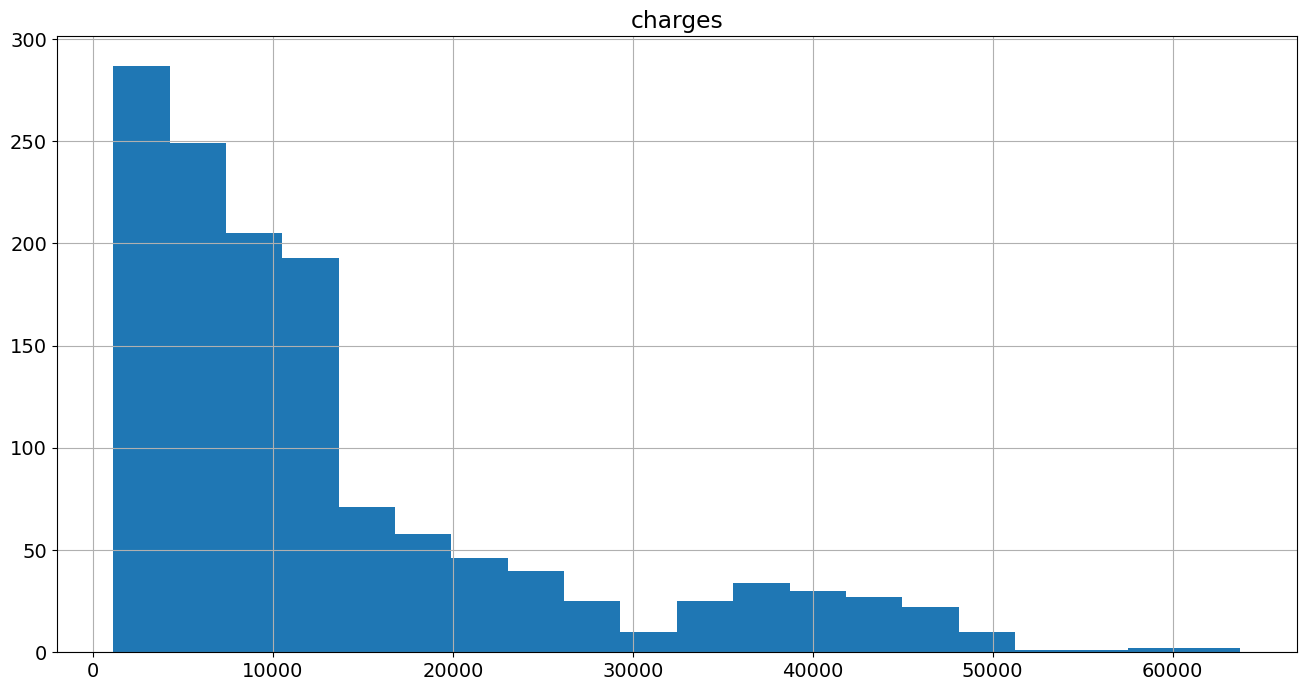

In [2]:
# check distribution of dependent variable-'charges'
df.hist(column='charges', bins=20)

array([[<AxesSubplot: title={'center': 'ln_charges'}>]], dtype=object)

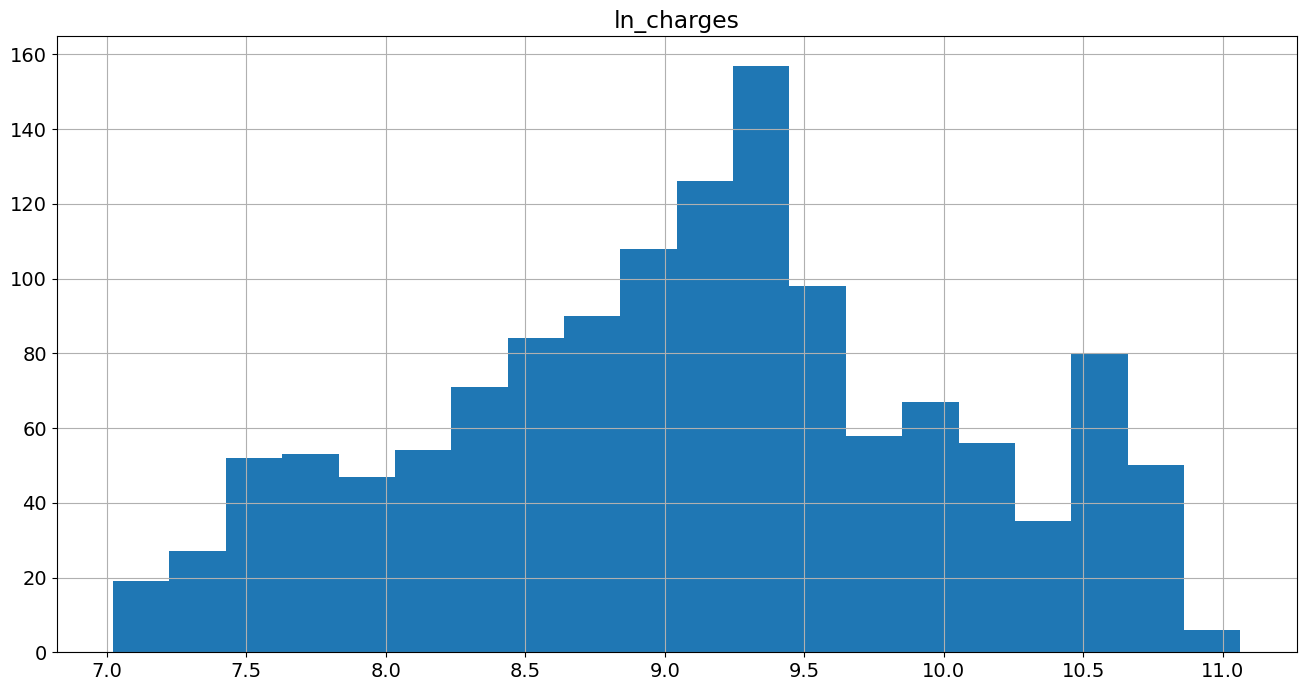

In [3]:
# normalize dependent variable
df['ln_charges'] = np.log(df['charges'])

df.hist(column='ln_charges', bins=20)

In [4]:
# display correlation matrix
print(df.corr().round(2))

             age   bmi  children  charges  ln_charges
age         1.00  0.11      0.04     0.30        0.53
bmi         0.11  1.00      0.01     0.20        0.13
children    0.04  0.01      1.00     0.07        0.16
charges     0.30  0.20      0.07     1.00        0.89
ln_charges  0.53  0.13      0.16     0.89        1.00


/home/nimnathw/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='age', ylabel='ln_charges'>

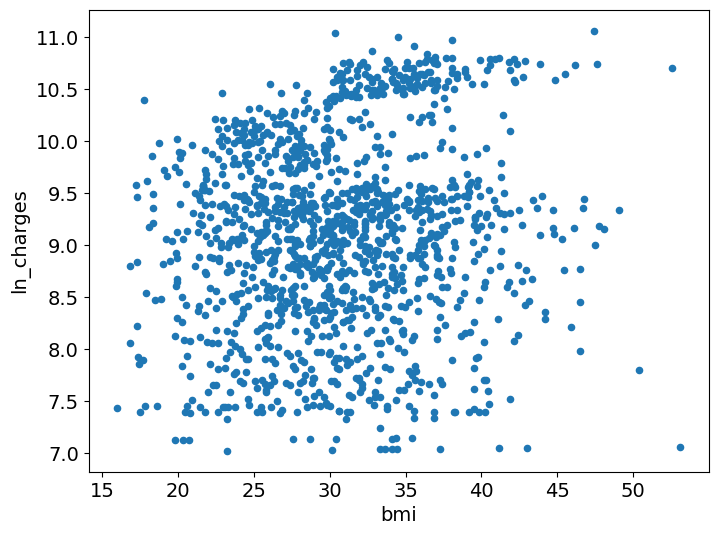

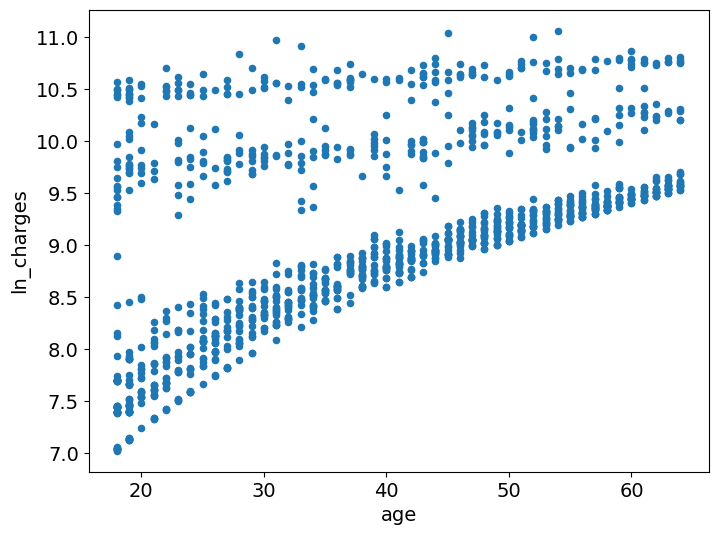

In [5]:
# display scatterplots
df.plot(kind='scatter', x='bmi', y='ln_charges', figsize=(8,6))
df.plot(kind='scatter', x='age', y='ln_charges', figsize=(8,6))

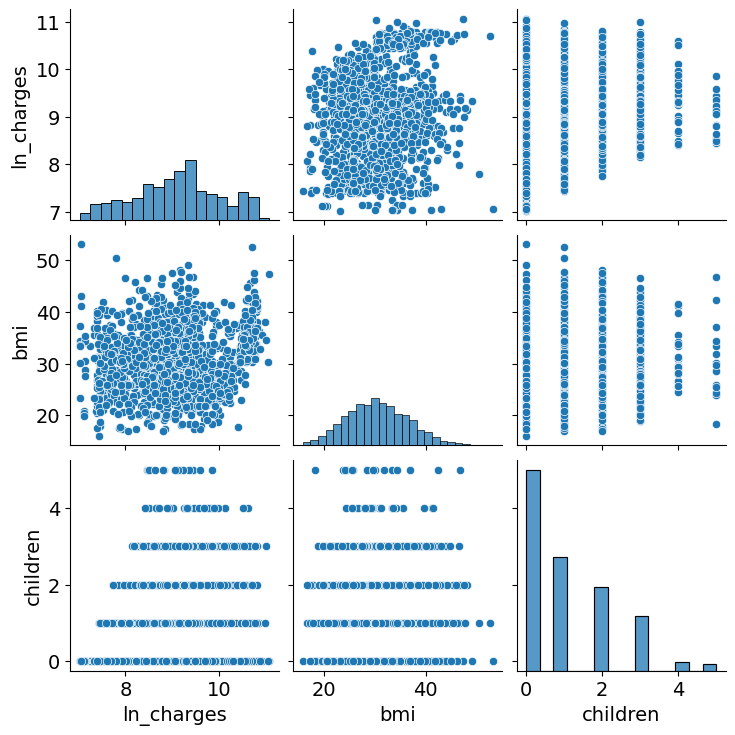

In [6]:
# plot numerical data as pairs
sns.pairplot(df[['ln_charges','bmi', 'children']])

In [7]:
# look for response categories
print(df['sex'].value_counts())
print(df['smoker'].value_counts())
print(df['region'].value_counts())

# convert string data to numerical
df['male'] = df['sex'] == 'male'
df['smoker'] = df['smoker'] == 'yes'

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


                            OLS Regression Results                            
Dep. Variable:             ln_charges   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     315.9
Date:                Thu, 22 Sep 2022   Prob (F-statistic):          3.26e-191
Time:                        15:52:28   Log-Likelihood:                -1339.7
No. Observations:                1338   AIC:                             2689.
Df Residuals:                    1333   BIC:                             2715.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          8.1032      0.095     85.

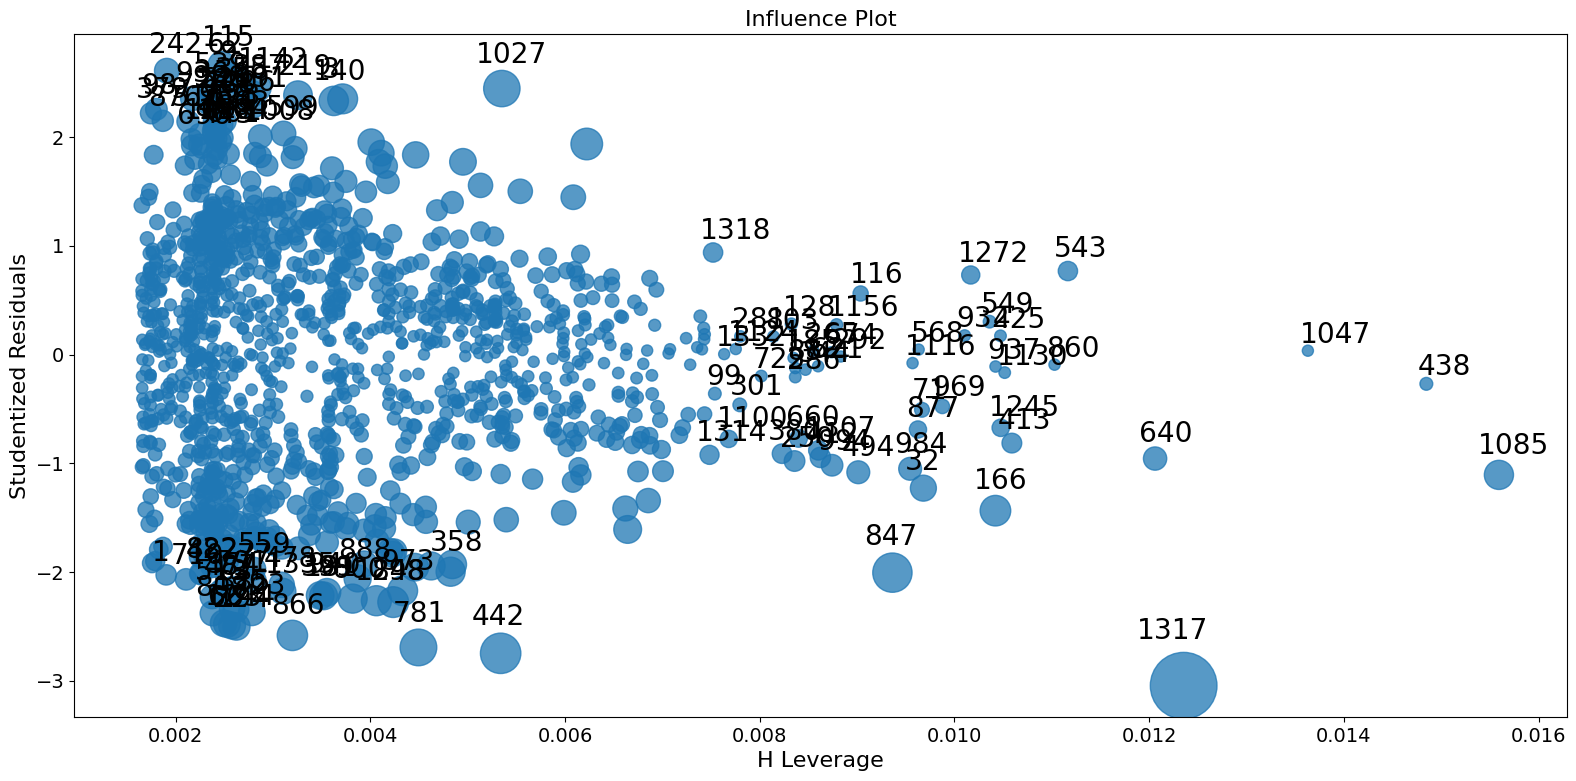

In [8]:
# screen dataset for outlier/ influencer data points
# estimate Linear Regression model
lm = ols('ln_charges ~ male + bmi + children + smoker', data=df).fit()

# display regression results
print(lm.summary())

# identify outlier/ influencer data points
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)

# compute Cook's distance 
lm_cooksd = lm.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(df['ln_charges'])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identify potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n", lm_cooksd[out_d])

2.0145774182275167

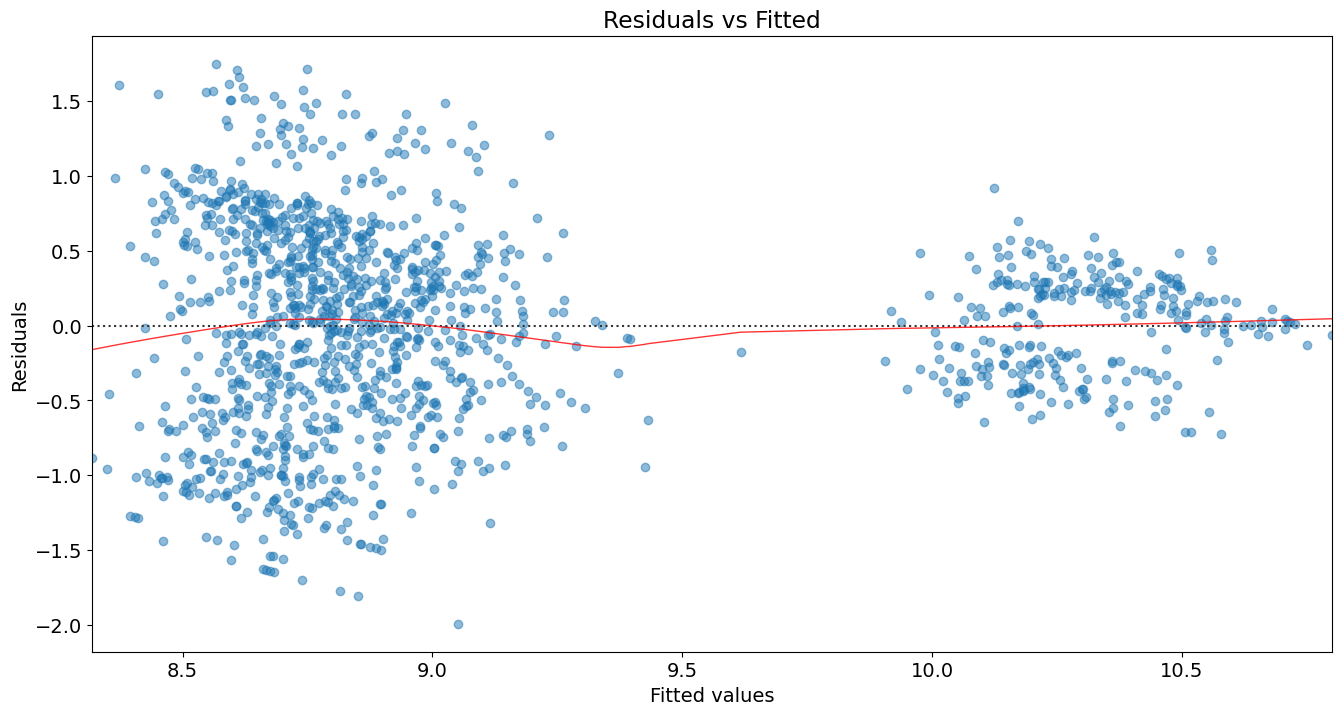

In [9]:
# screen data for heteroskedasticity
# fit values
model_fitted_y = lm.fittedvalues

#  plot residuals
plot = sns.residplot(x=model_fitted_y, y='ln_charges', data=df, lowess=True, 
                        scatter_kws={'alpha': 0.5}, 
                             line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot.set_title('Residuals vs Fitted')
plot.set_xlabel('Fitted values')
plot.set_ylabel('Residuals')

# compute Breusch-Pagan Lagrange Multiplier test for heteroskedasticity
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(lm.resid, lm.model.exog)
lzip(name, test)

# compute Dublin Watson statistic for auto-colinearity
sm.stats.durbin_watson(lm.resid)

,VIF Factor,Feature
0,27.78,Intercept
1,1.01,male[T.True]
2,1.01,smoker[T.True]
3,1.00,bmi
4,1.00,children


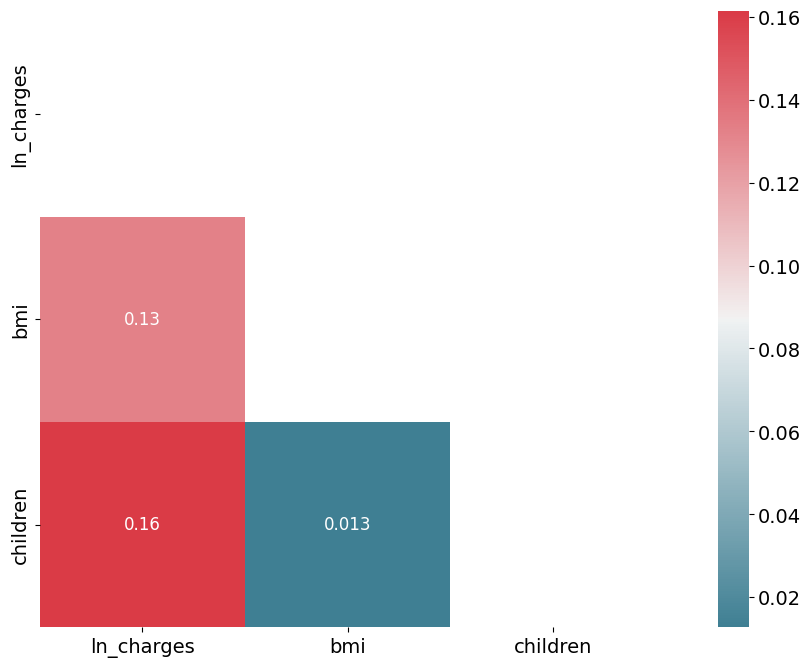

In [10]:
# screen for non-normally distributed errors (Jarque-Bera Test)
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(lm.resid)

lzip(name, test)

# screen for non-normally distributed errors (Omnibus normtest)
name = ['Chi^2', 'Two-tail probability']
test = sm.stats.omni_normtest(lm.resid)
lzip(name, test)


# inspect correlation
# compute correlation
corr = df[['ln_charges','bmi', 'children']].corr()

# optimize aesthetics  (generate mask for removing duplicates)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plot
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True,  square=True, annot_kws={"size": 12});

# compute VIF value for multicolinearity
y, X = dmatrices('ln_charges ~ male + bmi + children + smoker', df, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns

vif.round(2)

In [11]:
# create Numpy 1-D and 2-D arrays for two models
X1 = df[['male', 'bmi', 'children', 'smoker']].values
y = df['ln_charges'].values

X2 = df[['male', 'bmi', 'children', 'smoker']].values
y = df['ln_charges'].values

# split data into train test sets
X1_train, X1_test, y_train, Y_test = train_test_split(X1, y, test_size = 0.3, random_state=1)

# initialize Linear Regression model
model = LinearRegression()

# fit model
model.fit(X1_train, y_train)

# predict y values on test set
y_test_predicted = model.predict(X1_test)

# split data into train test sets
# same random_state to ensure the same splits
X2_train, X2_test, y_train, y_test = train_test_split(X2, y,  test_size = 0.3, random_state=1)

# initialize Linear Regression model
model2 = LinearRegression()

# fit model
model2.fit(X2_train, y_train)

# predict y values on test set
y_test_predicted2 = model2.predict(X2_test)

# show mean squared errors
print("Mean squared error")
print(mean_squared_error(y_test, y_test_predicted2).round(2))

# show R-squared
print("\nR_squared score")
print(r2_score(y_test, y_test_predicted2).round(2))

# show model coefficients
print('\nmodel intercept')
print(model.intercept_.round(4))
print('\nmodel coefficents: percentage change in Y  to a change in X')
print(pd.DataFrame(model.coef_.round(4), df[['male', 'bmi', 'children', 'smoker']].columns, columns=['coef']).sort_values(by='coef', ascending=False))


Mean squared error
0.45

R_squared score
0.47

model intercept
8.0945

model coefficents: percentage change in Y  to a change in X
            coef
smoker    1.5428
children  0.1012
bmi       0.0201
male     -0.0889
